# My First TensorFlow Code

We will try to build a customisable, fully connected Neural Network. We'll need to use tf_utils to load dataset. We'll check later how to read h5 datasets.

In [1]:
import numpy as np
import h5py
from tf_utils import load_dataset, random_mini_batches
import tensorflow as tf
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt

%matplotlib inline

/Users/Aniket/anaconda3/envs/aniket1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/Aniket/anaconda3/envs/aniket1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/Aniket/anaconda3/envs/aniket1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/Aniket/anaconda3/envs/aniket1/lib

Now we've imported everything. Let's write out some basic routines now.

First thing, create placeholders for the input and output data. We keep the shape of X (input) and Y (output) totally free. Will see if this creates some problems later on.

In [2]:
def create_placeholder(nx, ny) : 
    X = tf.placeholder(dtype = tf.float32, shape = [nx, None], name = 'X')
    Y = tf.placeholder(dtype = tf.float32, shape = [ny, None], name = 'Y')
    return X, Y

Now we've got this in place. Let's make some neural networks! We want to create tf.Variables to represent matrices corresponding to each layer. Variables are the ones tf performs derivatives etc. 

We also take in a list of numbers corresponding to number of neurons in each layer. Return lists containing matrices and biases corresponding to each layer. So first one is of shape (layer 1, input_size)...(output size, layer n-1).

**NOTE** : List should include input size as first number and output size as last number. 

In [3]:
def initialize_parameters():
    tf.set_random_seed(1)                   # so that your "random" numbers match ours
        
    ### START CODE HERE ### (approx. 6 lines of code)
    W1 = tf.get_variable("W1", [25, 12288], initializer= tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [25, 1], initializer= tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12, 25], initializer= tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [12, 1], initializer= tf.zeros_initializer())
    W3 = tf.get_variable("W3", [6, 12], initializer= tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [6, 1], initializer= tf.zeros_initializer())
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [4]:
def initialize_params(num_neurons) :    
    n_layers = len(num_neurons)
    Warr = [] 
    barr = []
    for i in np.arange(n_layers-1) : 
        Warr.append(tf.get_variable(dtype = tf.float32, \
        shape = [num_neurons[i+1], num_neurons[i]], name = 'W{}'.format(i), \
            initializer = tf.contrib.layers.xavier_initializer(seed = 1)))
        barr.append(tf.get_variable(dtype = tf.float32, name = 'b{}'.format(i), \
        shape = [num_neurons[i+1], 1], initializer = tf.zeros_initializer()))
    params = {'W' : Warr, 'b' : barr}
    return params

Next we'll do a forward propagation. We take as input the data vector X, parameter dictionary, and the list of layers. We choose ReLU as the activation function. The output should be just the linear transform of the penultimate layer. The cost function in tf automatically performs a softmax activation. 

In [5]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    ### START CODE HERE ### (approx. 5 lines)              # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                                              # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                              # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                                              # Z2 = np.dot(W2, A1) + b2
    A2 = tf.nn.relu(Z2)                                              # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                                              # Z3 = np.dot(W3, A2) + b3
    ### END CODE HERE ###
    
    return Z3

In [6]:
def forward_prop(X, params, num_neurons) :
    Warr = params['W']
    barr = params['b']
    n_layers = len(num_neurons)
    Z = tf.add(tf.matmul(Warr[0], X), barr[0]) #if there's only one layer it's logistic regression, directly return Z
    for i in np.arange(1, n_layers-1) : 
        A = tf.nn.relu(Z)
        Z = tf.add(tf.matmul(Warr[i], A), barr[i])
    return Z

We've now put together all pieces we need for the network itself. Let's now focus on the cost function. We want to use a softmax cost. So we need to ensure that the labels in our training set are represented as vectors with a 1 at the corresponding index - so-called one-hot encoding. Let's write a function to do this explicitly. We need to input the list of labels from 0 to C and C, where C is the number of classes. 

In [7]:
def one_hot_encoding(labels, C) : 
    one_hot_ans = tf.one_hot(labels, depth=C, axis = 0)
    sess = tf.Session()
    one_hot = sess.run(one_hot_ans)
    sess.close()
    return one_hot

Now we write the cost function. We use the softmax cross entropy. One thing to note is that the output Z from forward_prop and the one_hot matrix of labels from one_hot_encoding has the shape (# classes, # examples). However, softmax_cross_entropy assumes that the shape is (# examples, # classes). So we should transpose.

In [8]:
def cost_fn(Z, Y) : 
    logits = tf.transpose(Z)
    labels = tf.transpose(Y)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    return cost

Ok. Now all components of our network are ready. Let's put them all together. 

**Note** : Again X_train should have shape (# features, # examples), Y_train should have shape (# classes, # examples)

In [9]:
def model(X_train, Y_train, X_test, Y_test, num_neurons, minibatch_size = 32, 
          num_epochs = 50, learn_rate = 0.0001, print_cost = True) : 
    #first some basic stuff
    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed = 3
    costs = []
    
    nfeat, nexamples = X_train.shape
    nclasses = Y_train.shape[0]
    #create placeholders for data
    X, Y = create_placeholder(nfeat, nclasses)
    #create variables for NN
    params = initialize_params(num_neurons) 
    #params = initialize_parameters()
    #forward propagation
    Z1 = forward_prop(X, params, num_neurons)  
    #Z1 = forward_propagation(X, params)
    #print(Z1.shape)
    #calculate cost
    cost = cost_fn(Z1, Y) 
    #Adam optimizer to minimize cost
    optimizer = tf.train.AdamOptimizer(learning_rate=learn_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    with tf.Session() as sess :
        #initialize variables
        sess.run(init)
        
        #run epochs to divide data into mini-batches and use stochastic gradient descent
        for epoch in np.arange(num_epochs) : 
          
            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(nexamples / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            
            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run session to execute "optimizer" and "cost", the feedict containd a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict = {X : minibatch_X, Y : minibatch_Y})
                epoch_cost += minibatch_cost / minibatch_size

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per fives)')
        plt.title("Learning rate =" + str(learn_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(params)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z1), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        
        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters           

Now we'll try to run on the dataset provided. 

In [10]:
# Loading the dataset
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

This data is in the shape of images. We need to flatten it out and normalize to feed into our NN. 

In [11]:
X_train_flat = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flat = X_test_orig.reshape(X_test_orig.shape[0], -1).T
X_train = X_train_flat/255
X_test = X_test_flat/255
Y_train = one_hot_encoding(np.squeeze(Y_train_orig), 6)
Y_test = one_hot_encoding(np.squeeze(Y_test_orig), 6)

We specify the architecture of the neural network now.

In [25]:
num_neurons = [X_train.shape[0], 25, 12, Y_train.shape[0]]

We're now ready to put things into our model.

Cost after epoch 0: 1.913693


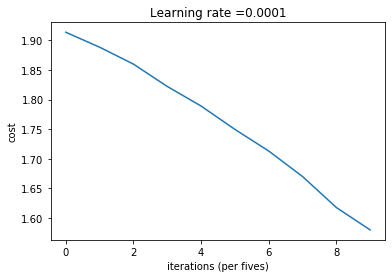

Parameters have been trained!
Train Accuracy: 0.38981482
Test Accuracy: 0.39166668


In [26]:
parameters = model(X_train, Y_train, X_test, Y_test, num_neurons, learn_rate = 0.0001, num_epochs = 50)